# Node/Edge Removal Analysis Notebook

This notebook mirrors the shell helpers under `analysis/`:

1. Read every `EBE_*.dat` file
2. Compute the same column-wise statistics as `statistical_analysis`
3. Extract finite-size-scaling (FSS) curves
4. Fit the power law `y = A N^\alpha` and plot

Adjust `DATA_DIR` below if your files live elsewhere.

In [1]:
from __future__ import annotations

import math
import re
from pathlib import Path
from typing import Dict, Iterable, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import analysis_utils as au

plt.style.use('seaborn-v0_8-colorblind')


## Paths and constants

In [2]:
ROOT_DIR = Path(__file__).resolve().parent if '__file__' in globals() else Path.cwd()
CONFIGS = {
    'node': {
        'folder': 'node_percolation',
        'file_prefix': 'NR_EBE_',
        'ci_radius': 2,
    },
    'link': {
        'folder': 'link_percolation',
        'file_prefix': 'LR_EBE_',
        'ci_radius': 0,
    },
}

DATASET = 'node'  # choose 'node' or 'link'
cfg = CONFIGS[DATASET]
DATA_DIR = ROOT_DIR / cfg['folder']
FILE_PREFIX = cfg['file_prefix']
CI_RADIUS_FILTER = cfg['ci_radius']
pat = f"{FILE_PREFIX}*.dat"
stats_name = f"stats_{FILE_PREFIX}*.dat"
OUTPUT_DIR = DATA_DIR
DATA_DIR.mkdir(parents=True, exist_ok=True)


## Column metadata

In [3]:
COLUMN_MAP = au.COLUMN_MAP
COLUMN_LOOKUP = au.COLUMN_LOOKUP


## IO helpers

## FSS extraction + power law fit

In [4]:
au.compute_effective_exponents.__doc__


'Sliding-window effective exponents via weighted log-log fits.'

## Example workflow

In [5]:
summary = au.process_all_ebe(DATA_DIR, OUTPUT_DIR, pattern=pat, ci_radius_filter=CI_RADIUS_FILTER)
summary[['file', 'ci_radius', 'M_graphs', 'runs', 'N']]


,file,ci_radius,M_graphs,runs,N
0,NR_EBE_NR_ER_N1048576_c4.00_ci_L2_Mg10000_Mr1.dat,2,10000,10000,1048576
1,NR_EBE_NR_ER_N131072_c4.00_ci_L2_Mg10000_Mr1.dat,2,10000,10000,131072
2,NR_EBE_NR_ER_N16384_c4.00_ci_L2_Mg10000_Mr1.dat,2,10000,10000,16384
3,NR_EBE_NR_ER_N2097152_c4.00_ci_L2_Mg10000_Mr1.dat,2,10000,10000,2097152
4,NR_EBE_NR_ER_N262144_c4.00_ci_L2_Mg10000_Mr1.dat,2,10000,10000,262144
5,NR_EBE_NR_ER_N32768_c4.00_ci_L2_Mg10000_Mr1.dat,2,10000,10000,32768
6,NR_EBE_NR_ER_N4096_c4.00_ci_L2_Mg10000_Mr1.dat,2,10000,10000,4096
7,NR_EBE_NR_ER_N4194304_c4.00_ci_L2_Mg10000_Mr1.dat,2,10000,10000,4194304
8,NR_EBE_NR_ER_N524288_c4.00_ci_L2_Mg10000_Mr1.dat,2,10000,10000,524288
9,NR_EBE_NR_ER_N65536_c4.00_ci_L2_Mg10000_Mr1.dat,2,10000,10000,65536


In [6]:
stats_files = [
    path
    for path in sorted(OUTPUT_DIR.glob(stats_name))
    if (CI_RADIUS_FILTER is None or au.extract_ci_radius(path.name) == CI_RADIUS_FILTER)
]
stats_files[:3], len(stats_files)


([PosixPath('/nfs/nfs2/home/hanlsun/global_removal/node_percolation/stats_NR_EBE_NR_ER_N1048576_c4.00_ci_L2_Mg10000_Mr1.dat'),
  PosixPath('/nfs/nfs2/home/hanlsun/global_removal/node_percolation/stats_NR_EBE_NR_ER_N131072_c4.00_ci_L2_Mg10000_Mr1.dat'),
  PosixPath('/nfs/nfs2/home/hanlsun/global_removal/node_percolation/stats_NR_EBE_NR_ER_N16384_c4.00_ci_L2_Mg10000_Mr1.dat')],
 11)

In [7]:
OBSERVABLES = [
    ("P(p+)", 4),
    ("P(q0)", 14),
]

fss_results = {}
fit_results = {}
for label, row in OBSERVABLES:
    fss = au.extract_fss(stats_files, row=row, value_kind='mean')
    fss_results[label] = fss
    fit_results[label] = au.weighted_log_fit(fss) if not fss.empty else None


/nfs/nfs2/home/hanlsun/global_removal/analysis_utils.py:237: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  value = float(row_data["mean"])
/nfs/nfs2/home/hanlsun/global_removal/analysis_utils.py:238: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  error = float(row_data["err_mean"])


In [8]:
EFFECTIVE_WINDOW = 3  # points per window for effective exponents


In [9]:
fss_results['P(p+)'], fit_results['P(p+)']


(          N        value       error  \
 0      4096    1123.2469    3.562113   
 1      8192    1901.4567    6.317034   
 2     16384    3156.4833   10.864428   
 3     32768    5218.4061   18.604590   
 4     65536    8643.0150   31.481392   
 5    131072   14197.0001   52.391866   
 6    262144   22965.5332   86.417628   
 7    524288   37180.6355  142.443243   
 8   1048576   60286.2670  235.942475   
 9   2097152   96779.1535  384.027884   
 10  4194304  155710.7560  620.658966   
 
                                                source  
 0   stats_NR_EBE_NR_ER_N4096_c4.00_ci_L2_Mg10000_M...  
 1   stats_NR_EBE_NR_ER_N8192_c4.00_ci_L2_Mg10000_M...  
 2   stats_NR_EBE_NR_ER_N16384_c4.00_ci_L2_Mg10000_...  
 3   stats_NR_EBE_NR_ER_N32768_c4.00_ci_L2_Mg10000_...  
 4   stats_NR_EBE_NR_ER_N65536_c4.00_ci_L2_Mg10000_...  
 5   stats_NR_EBE_NR_ER_N131072_c4.00_ci_L2_Mg10000...  
 6   stats_NR_EBE_NR_ER_N262144_c4.00_ci_L2_Mg10000...  
 7   stats_NR_EBE_NR_ER_N524288_c4.00_ci_L2_Mg1000

In [10]:
fss_results['P(q0)'], fit_results['P(q0)']


(          N       value       error  \
 0      4096    681.2591    3.067337   
 1      8192   1151.3239    5.480103   
 2     16384   1881.8439    9.052012   
 3     32768   3103.8380   15.229070   
 4     65536   5066.7689   25.221735   
 5    131072   8301.0235   41.526965   
 6    262144  13394.3343   68.093485   
 7    524288  21564.0374  110.165027   
 8   1048576  34842.7318  179.063352   
 9   2097152  55897.0949  289.395936   
 10  4194304  89566.3886  472.303049   
 
                                                source  
 0   stats_NR_EBE_NR_ER_N4096_c4.00_ci_L2_Mg10000_M...  
 1   stats_NR_EBE_NR_ER_N8192_c4.00_ci_L2_Mg10000_M...  
 2   stats_NR_EBE_NR_ER_N16384_c4.00_ci_L2_Mg10000_...  
 3   stats_NR_EBE_NR_ER_N32768_c4.00_ci_L2_Mg10000_...  
 4   stats_NR_EBE_NR_ER_N65536_c4.00_ci_L2_Mg10000_...  
 5   stats_NR_EBE_NR_ER_N131072_c4.00_ci_L2_Mg10000...  
 6   stats_NR_EBE_NR_ER_N262144_c4.00_ci_L2_Mg10000...  
 7   stats_NR_EBE_NR_ER_N524288_c4.00_ci_L2_Mg10000...  
 8   

## Giant component vs removed fraction

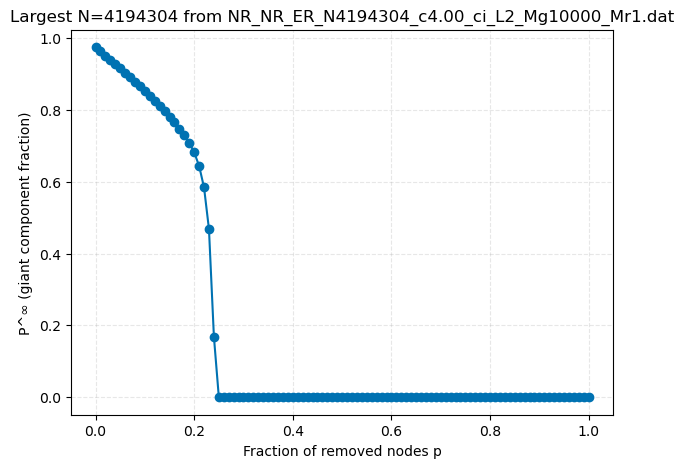

In [11]:
au.plot_giant_component_vs_p(DATA_DIR, FILE_PREFIX, CI_RADIUS_FILTER)


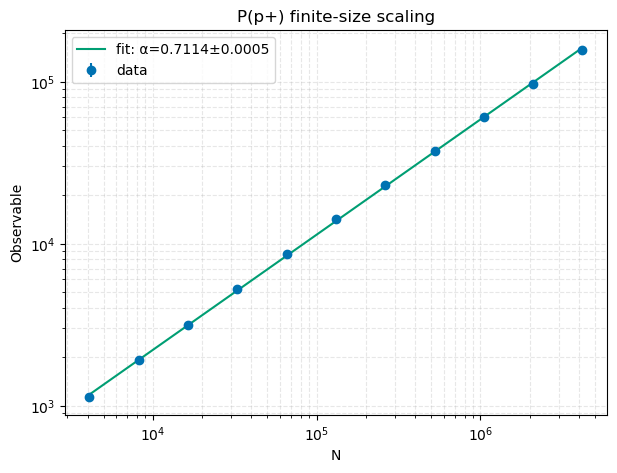

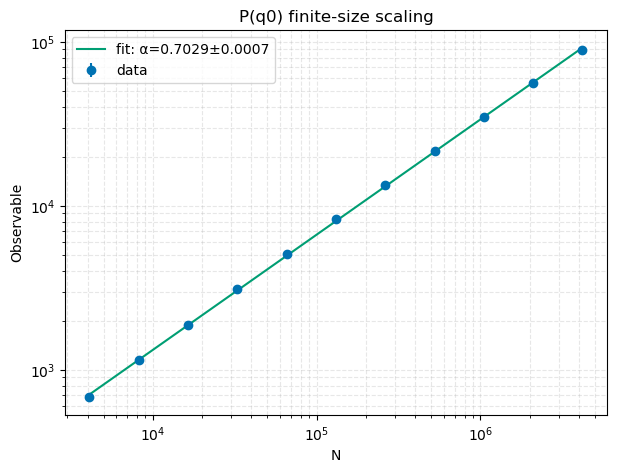

In [12]:
for label, _ in OBSERVABLES:
    fss = fss_results[label]
    fit = fit_results[label]
    if fss.empty or fit is None:
        print(f'No data for {label}')
        continue
    au.plot_fss_with_fit(fss, fit, title=f"{label} finite-size scaling")


/nfs/nfs2/home/hanlsun/global_removal/analysis_utils.py:237: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  value = float(row_data["mean"])
/nfs/nfs2/home/hanlsun/global_removal/analysis_utils.py:238: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  error = float(row_data["err_mean"])


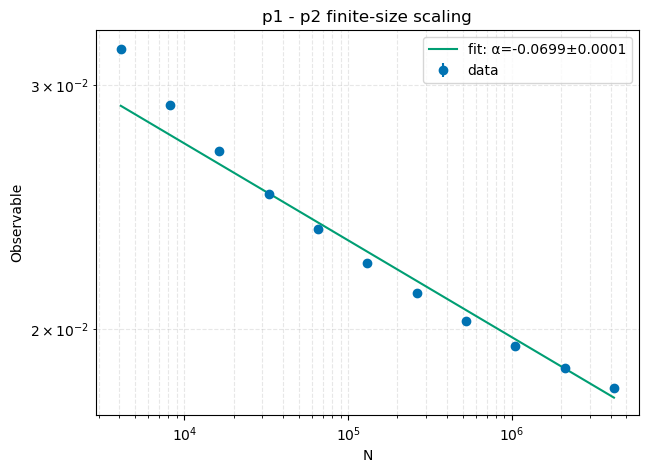

In [13]:
fss_gap = au.extract_p1_minus_p2(stats_files, value_kind='mean')
fit_gap = au.weighted_log_fit(fss_gap)
au.plot_fss_with_fit(fss_gap, fit_gap, title='p1 - p2 finite-size scaling')


In [14]:
effective_results = {}
for label, _ in OBSERVABLES:
    fss = fss_results[label]
    if fss.empty:
        effective_results[label] = pd.DataFrame()
    else:
        effective_results[label] = au.compute_effective_exponents(fss, window=EFFECTIVE_WINDOW)


In [15]:
effective_results['P(p+)']


,N_left,N_right,N_geom,exponent,exponent_err
0,4096.0,16384.0,8192.0,0.745704,0.003372
1,8192.0,32768.0,16384.0,0.728322,0.003512
2,16384.0,65536.0,32768.0,0.726584,0.003613
3,32768.0,131072.0,65536.0,0.722021,0.003701
4,65536.0,262144.0,131072.0,0.705052,0.003777
5,131072.0,524288.0,262144.0,0.694475,0.003836
6,262144.0,1048576.0,524288.0,0.696165,0.003915
7,524288.0,2097152.0,1048576.0,0.690156,0.003978
8,1048576.0,4194304.0,2097152.0,0.684474,0.004029


In [16]:
effective_results['P(q0)']


,N_left,N_right,N_geom,exponent,exponent_err
0,4096.0,16384.0,8192.0,0.733451,0.004749
1,8192.0,32768.0,16384.0,0.715313,0.004930
2,16384.0,65536.0,32768.0,0.714544,0.004992
3,32768.0,131072.0,65536.0,0.709601,0.005054
4,65536.0,262144.0,131072.0,0.701320,0.005132
5,131072.0,524288.0,262144.0,0.688644,0.005157
6,262144.0,1048576.0,524288.0,0.689608,0.005214
7,524288.0,2097152.0,1048576.0,0.687096,0.005247
8,1048576.0,4194304.0,2097152.0,0.681057,0.005311


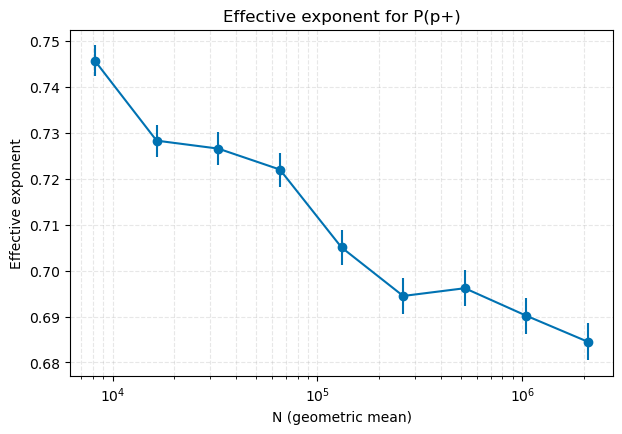

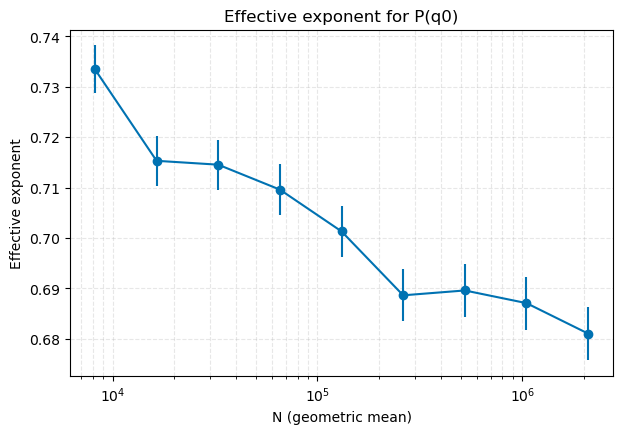

In [17]:
for label, _ in OBSERVABLES:
    eff = effective_results[label]
    if eff.empty:
        print(f'No effective exponents for {label}')
        continue
    au.plot_effective_exponent(eff, title=f"Effective exponent for {label}")


## Jump-height scaling

Plot the normalized jump height dP(p+) versus system size and fit a power law in log-log space.

/nfs/nfs2/home/hanlsun/global_removal/analysis_utils.py:237: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  value = float(row_data["mean"])
/nfs/nfs2/home/hanlsun/global_removal/analysis_utils.py:238: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  error = float(row_data["err_mean"])


          N     value     error
0      4096  0.087879  0.000322
1      8192  0.072042  0.000269
2     16384  0.058725  0.000227
3     32768  0.047393  0.000186
4     65536  0.038090  0.000149
5    131072  0.030867  0.000123
6    262144  0.024646  0.000099
7    524288  0.019792  0.000080
8   1048576  0.015909  0.000066
9   2097152  0.012644  0.000052
10  4194304  0.010082  0.000042
Jump-height fit: {'A': 1.2137024287217448, 'A_err': 0.007752351733377788, 'alpha': np.float64(-0.3129135436165303), 'alpha_err': 0.0005400083285559209, 'chi2_red': 11.478172077739194, 'fit_used_abs': False, 'fit_value_sign': 1.0}


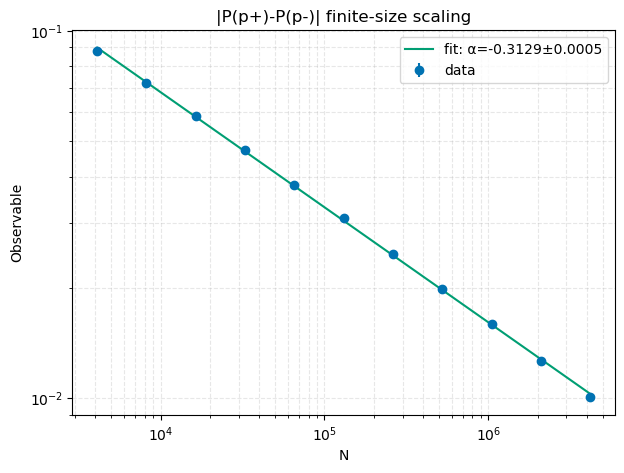

In [18]:
jump_fss = au.extract_fss(stats_files, row=3, value_kind='mean')
if jump_fss.empty:
    print('No jump-height data found; regenerate stats with updated binaries.')
else:
    jump_fit = au.weighted_log_fit(jump_fss)
    print(jump_fss[['N', 'value', 'error']])
    print('Jump-height fit:', jump_fit)
    au.plot_fss_with_fit(jump_fss, jump_fit, title='|P(p+)-P(p-)| finite-size scaling')


## Jump-height effective exponent

Local effective exponent for dP(p+) using the configured window.


      N_left    N_right     N_geom  exponent  exponent_err
0     4096.0    16384.0     8192.0 -0.290696      0.003841
1     8192.0    32768.0    16384.0 -0.301957      0.003910
2    16384.0    65536.0    32768.0 -0.312276      0.003970
3    32768.0   131072.0    65536.0 -0.309350      0.004045
4    65536.0   262144.0   131072.0 -0.313961      0.004041
5   131072.0   524288.0   262144.0 -0.320581      0.004113
6   262144.0  1048576.0   524288.0 -0.315764      0.004163
7   524288.0  2097152.0  1048576.0 -0.323231      0.004169
8  1048576.0  4194304.0  2097152.0 -0.329034      0.004223


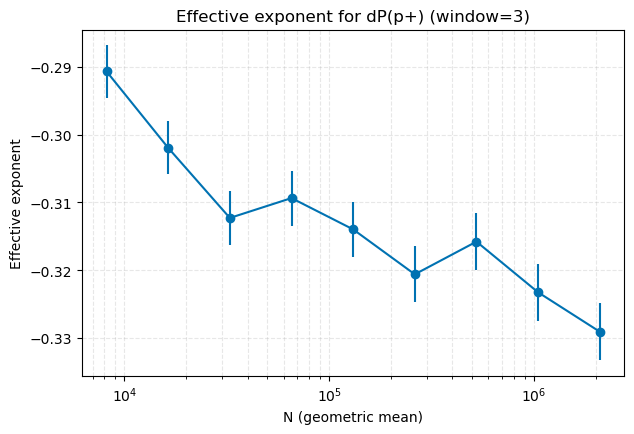

In [19]:
jump_eff = pd.DataFrame()
if 'jump_fss' not in globals():
    print('jump_fss not defined; run the jump-height cell first.')
elif jump_fss.empty:
    print('No effective exponents for jump height')
else:
    jump_eff = au.compute_effective_exponents(jump_fss, window=EFFECTIVE_WINDOW)
    print(jump_eff)
    au.plot_effective_exponent(jump_eff, title=f'Effective exponent for dP(p+) (window={EFFECTIVE_WINDOW})')
